<a href="https://colab.research.google.com/github/JosueAfouda/Coursera_Capstone/blob/master/AFOUDA_coursera_sp500_stock_price_forecasting.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Libraries

In [ ]:
import pandas as pd
import plotly.express as px
from copy import copy
from scipy import stats
import matplotlib.pyplot as plt
import numpy as np
import plotly.figure_factory as ff
from sklearn.metrics import r2_score
from tensorflow import keras


# PROBLEM STATEMENT & BUSINESS CASE

* **Stock prices are volatiles and hard to forecast** ;

* **A lot of financial institutions are relying on Machine Learning and Deep Learning for stock prices forecasting because these techniques can help to reduce risk and maximize return for the investors or traders**.

# OBJECTIVES OF THIS PROJECT

In tis project, i'm going to perform S&P500 stock prices forecasting. The main objectives of this project are :

* **Collecting S&P500 stock prices data from [Yahoo Finance](https://finance.yahoo.com/quote/%5EGSPC?p=^GSPC&.tsrc=fin-srch)** ;

* **Performing an Exploratory Data Analysis (EDA)** ;

* **Building and Evaluating of a LSTM model to forecast stock prices**.

# DESCRIBING OF THE DATA

The S&P 500 stock market index comprises 505 common stocks issued by 500 large-cap companies and traded on American stock exchanges and covers about 80% of the American equity market by capitalization (Credit : https://en.wikipedia.org/wiki/List_of_S%26P_500_companies).

Let's know these companies :

In [ ]:
# List of S&P500 companies

sp500_list = pd.read_html('https://en.wikipedia.org/wiki/List_of_S%26P_500_companies')
sp500_list = sp500_list[0]
sp500_list

,Symbol,Security,SEC filings,GICS Sector,GICS Sub-Industry,Headquarters Location,Date first added,CIK,Founded
0,MMM,3M Company,reports,Industrials,Industrial Conglomerates,"St. Paul, Minnesota",1976-08-09,66740,1902
1,ABT,Abbott Laboratories,reports,Health Care,Health Care Equipment,"North Chicago, Illinois",1964-03-31,1800,1888
2,ABBV,AbbVie Inc.,reports,Health Care,Pharmaceuticals,"North Chicago, Illinois",2012-12-31,1551152,2013 (1888)
3,ABMD,ABIOMED Inc,reports,Health Care,Health Care Equipment,"Danvers, Massachusetts",2018-05-31,815094,1981
4,ACN,Accenture plc,reports,Information Technology,IT Consulting & Other Services,"Dublin, Ireland",2011-07-06,1467373,1989
...,...,...,...,...,...,...,...,...,...
500,YUM,Yum! Brands Inc,reports,Consumer Discretionary,Restaurants,"Louisville, Kentucky",1997-10-06,1041061,1997
501,ZBRA,Zebra Technologies,reports,Information Technology,Electronic Equipment & Instruments,"Lincolnshire, Illinois",2019-12-23,877212,1969
502,ZBH,Zimmer Biomet Holdings,reports,Health Care,Health Care Equipment,"Warsaw, Indiana",2001-08-07,1136869,1927
503,ZION,Zions Bancorp,reports,Financials,Regional Banks,"Salt Lake City, Utah",2001-06-22,109380,1873


I will use S&P500 daily historical data from October 18, 2010 to October 16, 2020. The data are collected from [Yahoo Finance](https://finance.yahoo.com/quote/%5EGSPC/history?period1=1287273600&period2=1602892800&interval=1d&filter=history&frequency=1d&includeAdjustedClose=true).

In [ ]:
# import sp500 stock prices data

raw_df = pd.read_csv('https://query1.finance.yahoo.com/v7/finance/download/%5EGSPC?period1=1287273600&period2=1602979200&interval=1d&events=history&includeAdjustedClose=true')

raw_df

,Date,Open,High,Low,Close,Adj Close,Volume
0,2010-10-18,1176.829956,1185.530029,1174.550049,1184.709961,1184.709961,4450050000
1,2010-10-19,1178.640015,1178.640015,1159.709961,1165.900024,1165.900024,5600120000
2,2010-10-20,1166.739990,1182.939941,1166.739990,1178.170044,1178.170044,5027880000
3,2010-10-21,1179.819946,1189.430054,1171.170044,1180.260010,1180.260010,4625470000
4,2010-10-22,1180.520020,1183.930054,1178.989990,1183.079956,1183.079956,3177890000
...,...,...,...,...,...,...,...
2513,2020-10-12,3500.020020,3549.850098,3499.610107,3534.219971,3534.219971,3428970000
2514,2020-10-13,3534.010010,3534.010010,3500.860107,3511.929932,3511.929932,3605150000
2515,2020-10-14,3515.469971,3527.939941,3480.550049,3488.669922,3488.669922,3840630000
2516,2020-10-15,3453.719971,3489.080078,3440.889893,3483.340088,3483.340088,3717640000


The dataset contains 2158 observations and 7 variables :

* ***Date*** : date of the day ;

* ***Open*** : Index price at market opening ;

* ***High*** : highest price of the index reached during the day

* ***Low*** : lowest price of the index reached during the day

* ***Close*** : index price at the end of the day ;

* ***Adj Close*** : index adjusted price at the end of the day. The adjusted closing price takes into account various factors and, based on them, generates the actual value of the shares of the company. 

* ***Volume*** : number of shares traded during the day.

In [ ]:
# data informations

raw_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2518 entries, 0 to 2517
Data columns (total 7 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   Date       2518 non-null   object 
 1   Open       2518 non-null   float64
 2   High       2518 non-null   float64
 3   Low        2518 non-null   float64
 4   Close      2518 non-null   float64
 5   Adj Close  2518 non-null   float64
 6   Volume     2518 non-null   int64  
dtypes: float64(5), int64(1), object(1)
memory usage: 137.8+ KB


There is no missing values in the dataset and data in each column are in a good format.

Let's perform some exploratory data analysis (EDA) and visualization.

# EXPLORATORY DATA ANALYSIS AND VISUALIZATION

I will simplify the dataset by considering only the ***Date***, ***Adj Close*** and ***Volume*** variables.

In [ ]:
price_volume_df = raw_df[['Date', 'Adj Close', 'Volume']]

price_volume_df

,Date,Adj Close,Volume
0,2010-10-18,1184.709961,4450050000
1,2010-10-19,1165.900024,5600120000
2,2010-10-20,1178.170044,5027880000
3,2010-10-21,1180.260010,4625470000
4,2010-10-22,1183.079956,3177890000
...,...,...,...
2513,2020-10-12,3534.219971,3428970000
2514,2020-10-13,3511.929932,3605150000
2515,2020-10-14,3488.669922,3840630000
2516,2020-10-15,3483.340088,3717640000


In [ ]:
price_volume_df.describe()

,Adj Close,Volume
count,2518.000000,2.518000e+03
mean,2121.894078,3.738124e+09
std,615.734800,8.787082e+08
min,1099.229980,1.025000e+09
25%,1578.782532,3.241600e+09
50%,2075.345093,3.591310e+09
75%,2664.080078,4.056868e+09
max,3580.840088,9.044690e+09


Between 2010-10-18 and 2010-10-16 :

* **The average trading volume for S&P500 is 3.738124e+09** ;

* **The maximum trading volume for S&P500 is 9.044690e+09** ;

* **The average stock price of the S&P500 is 2121.894078$** ;

* **The maximum stock price of the S&P500 is 3580.840088$**.

Let's plot the volume and price series and their normalized data in a interactive way. In order to perform these visualizations, i will build two functions : one for interactive plot and one to normalize data.

In [ ]:
# Function to plot interactive plots
def interactive_plot(df, title):
  fig = px.line(title = title)
  for i in df.columns[1:]:
    fig.add_scatter(x = df['Date'], y = df[i], name = i)
  fig.show()

In [ ]:
# Function to normalize stock prices based on their initial price
def normalize(df):
  x = df.copy()
  for i in x.columns[1:]:
    x[i] = x[i]/x[i][0]
  return x

In [ ]:
interactive_plot(price_volume_df[['Date', 'Volume']], 'Volume of S&P500 shares')

In [ ]:
interactive_plot(price_volume_df[['Date', 'Adj Close']], ' Raw S&P500 prices')

**By analysis the plot of S&P500 prices, we can see that if we had put $1184.71 in S&P500 at 2010-10-18, we will have 3483.81 dollars at 2010-10-16**

**The index price was $3386.15 at 2020-02-19 and dropped to come to 2237.4 at 2020-03-23 when coronavirus has been declared a global pandemic. In this period, everyone was scared and selling their stocks (increasing volume of shares in this period). But as you can see the index price quickly bounded back to normal levels**.

In [ ]:
normalize(price_volume_df)

,Date,Adj Close,Volume
0,2010-10-18,1.000000,1.000000
1,2010-10-19,0.984123,1.258440
2,2010-10-20,0.994480,1.129848
3,2010-10-21,0.996244,1.039420
4,2010-10-22,0.998624,0.714125
...,...,...,...
2513,2020-10-12,2.983194,0.770546
2514,2020-10-13,2.964380,0.810137
2515,2020-10-14,2.944746,0.863053
2516,2020-10-15,2.940247,0.835415


**If you put one dollar in S&P500, it will be $2.940644 by 2010-10-16. The normalized stock prices data can help to compare return of many securities**.

In [ ]:
interactive_plot(normalize(price_volume_df[['Date', 'Adj Close']]), 'Normalized S&P500 prices')

Let's calculate the percentage daily return for S&P500 :

In [ ]:
price_volume_df['daily return (%)'] = price_volume_df['Adj Close'].pct_change()
price_volume_df

,Date,Adj Close,Volume,daily return (%)
0,2010-10-18,1184.709961,4450050000,NaN
1,2010-10-19,1165.900024,5600120000,-0.015877
2,2010-10-20,1178.170044,5027880000,0.010524
3,2010-10-21,1180.260010,4625470000,0.001774
4,2010-10-22,1183.079956,3177890000,0.002389
...,...,...,...,...
2513,2020-10-12,3534.219971,3428970000,0.016416
2514,2020-10-13,3511.929932,3605150000,-0.006307
2515,2020-10-14,3488.669922,3840630000,-0.006623
2516,2020-10-15,3483.340088,3717640000,-0.001528


In [ ]:
interactive_plot(price_volume_df[['Date', 'daily return (%)']].dropna(), 'Percentage daily return of S&P500')

Let's plot the histogram for daily return :

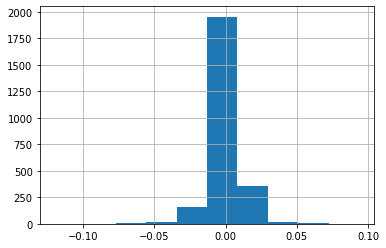

In [ ]:
price_volume_df['daily return (%)'].hist();

**The most of the daily returns are around the zero which makes sense because in general, there is no huge fluctuations in the daily stock price. The dispersion away from the mean (a.k.a standard deviation) wich is a measure of risk, is around between -5% and 5%**.

In [ ]:
del price_volume_df['daily return (%)']

# DATA PREPARATION

In [ ]:
# Get the close and volume data as training data (Input)
training_data = price_volume_df.iloc[:, 1:3].values
training_data

array([[1.18470996e+03, 4.45005000e+09],
       [1.16590002e+03, 5.60012000e+09],
       [1.17817004e+03, 5.02788000e+09],
       ...,
       [3.48866992e+03, 3.84063000e+09],
       [3.48334009e+03, 3.71764000e+09],
       [3.48381006e+03, 4.67589000e+09]])

In [ ]:
# Normalize the data
from sklearn.preprocessing import MinMaxScaler
sc = MinMaxScaler(feature_range = (0, 1))
training_set_scaled = sc.fit_transform(training_data)

In [ ]:
# Create the training and testing data, training data contains present day and previous day values
X = []
y = []
for i in range(1, len(price_volume_df)):
    X.append(training_set_scaled [i-1:i, 0])
    y.append(training_set_scaled [i, 0])

In [ ]:
# Convert the data into array format
X = np.asarray(X)
y = np.asarray(y)

In [ ]:
# Split the data
split = int(0.8 * len(X))
X_train = X[:split]
y_train = y[:split]
X_test = X[split:]
y_test = y[split:]

In [ ]:
# Reshape the 1D arrays to 3D arrays to feed in the model
X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], 1))
X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], 1))
X_train.shape, X_test.shape

((2013, 1, 1), (504, 1, 1))

# MODELING

It's time to build a LSTM model in order to forecast S&P500 stock price.

In [ ]:
# Create the model
inputs = keras.layers.Input(shape=(X_train.shape[1], X_train.shape[2]))
x = keras.layers.LSTM(150, return_sequences= True)(inputs)
x = keras.layers.Dropout(0.3)(x)
x = keras.layers.LSTM(150, return_sequences=True)(x)
x = keras.layers.Dropout(0.3)(x)
x = keras.layers.LSTM(150)(x)
outputs = keras.layers.Dense(1, activation='linear')(x)

model = keras.Model(inputs=inputs, outputs=outputs)
model.compile(optimizer='adam', loss="mse")
model.summary()

Model: "functional_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 1, 1)]            0         
_________________________________________________________________
lstm (LSTM)                  (None, 1, 150)            91200     
_________________________________________________________________
dropout (Dropout)            (None, 1, 150)            0         
_________________________________________________________________
lstm_1 (LSTM)                (None, 1, 150)            180600    
_________________________________________________________________
dropout_1 (Dropout)          (None, 1, 150)            0         
_________________________________________________________________
lstm_2 (LSTM)                (None, 150)               180600    
_________________________________________________________________
dense (Dense)                (None, 1)                

In [ ]:
# Trai the model
history = model.fit(
    X_train, y_train,
    epochs = 20,
    batch_size = 32,
    validation_split = 0.2
)

Epoch 1/20
51/51 [==============================] - 1s 21ms/step - loss: 0.0279 - val_loss: 0.0551
Epoch 2/20
51/51 [==============================] - 0s 8ms/step - loss: 0.0033 - val_loss: 0.0025
Epoch 3/20
51/51 [==============================] - 0s 7ms/step - loss: 3.9682e-04 - val_loss: 4.2173e-04
Epoch 4/20
51/51 [==============================] - 0s 8ms/step - loss: 3.5418e-04 - val_loss: 7.4660e-04
Epoch 5/20
51/51 [==============================] - 0s 8ms/step - loss: 3.3503e-04 - val_loss: 1.7279e-04
Epoch 6/20
51/51 [==============================] - 0s 8ms/step - loss: 3.7469e-04 - val_loss: 3.7151e-04
Epoch 7/20
51/51 [==============================] - 0s 8ms/step - loss: 2.8520e-04 - val_loss: 2.2039e-04
Epoch 8/20
51/51 [==============================] - 0s 8ms/step - loss: 2.9285e-04 - val_loss: 6.8481e-05
Epoch 9/20
51/51 [==============================] - 0s 8ms/step - loss: 2.9111e-04 - val_loss: 6.9629e-05
Epoch 10/20
51/51 [==============================] - 0s 8ms/s

In [ ]:
# Make prediction
predicted = model.predict(X)

In [ ]:
# Append the predicted values to the list
test_predicted = []

for i in predicted:
  test_predicted.append(i[0])

In [ ]:
df_predicted = price_volume_df[1:][['Date']]
df_predicted

,Date
1,2010-10-19
2,2010-10-20
3,2010-10-21
4,2010-10-22
5,2010-10-25
...,...
2513,2020-10-12
2514,2020-10-13
2515,2020-10-14
2516,2020-10-15


In [ ]:
df_predicted['predictions'] = test_predicted

In [ ]:
df_predicted

,Date,predictions
1,2010-10-19,0.040638
2,2010-10-20,0.032859
3,2010-10-21,0.037933
4,2010-10-22,0.038797
5,2010-10-25,0.039964
...,...,...
2513,2020-10-12,0.953627
2514,2020-10-13,0.974498
2515,2020-10-14,0.966363
2516,2020-10-15,0.957853


In [ ]:
# Plot the data
close = []
for i in training_set_scaled:
  close.append(i[0])


In [ ]:
df_predicted['Close'] = close[1:]

In [ ]:
df_predicted

,Date,predictions,Close
1,2010-10-19,0.040638,0.026866
2,2010-10-20,0.032859,0.031810
3,2010-10-21,0.037933,0.032652
4,2010-10-22,0.038797,0.033789
5,2010-10-25,0.039964,0.034812
...,...,...,...
2513,2020-10-12,0.953627,0.981214
2514,2020-10-13,0.974498,0.972232
2515,2020-10-14,0.966363,0.962859
2516,2020-10-15,0.957853,0.960711


In [ ]:
# Function to plot interactive plots
def interactive_plot(df, title):
  fig = px.line(title = title)
  for i in df.columns[1:]:
    fig.add_scatter(x = df['Date'], y = df[i], name = i)
  fig.show()

In [ ]:
# Plot the data
interactive_plot(df_predicted, "Original Vs Prediction")

The LSTM model performs well on the data.

In [ ]:
from google.colab import drive
drive.mount('/content/drive/')

Mounted at /content/drive/


In [ ]:
%%capture
!wget -nc https://raw.githubusercontent.com/brpy/colab-pdf/master/colab_pdf.py
from colab_pdf import colab_pdf
colab_pdf('AFOUDA_coursera_sp500_stock_price_forecasting.ipynb')